In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import mne
from mne.preprocessing import ICA
from torch.utils.data import Dataset,DataLoader
from utils_neuro import *
import librosa
from tqdm import trange


In [2]:
'''
dataset_maker:
    Input: .BDF파일, [제거할 ICA성분들(전처리)], min_hz, max_hz, min
    
    Output: (단어갯수, 길이(300), 채널(16)).
    
    단어갯수 = min*10
    
    []안에 있는건 ICA
    sampling rate = 100이니 길이는 3초를 의미. 
    
    
    requirement:
        pip3 install mne, librosa
    
'''
test5 = dataset_maker('data/test5_15.BDF',[0,1,11,13],0.01,40,15)
test6 = dataset_maker('data/test6.BDF',[0,1,5,9],0.01,40,10)
test7 = dataset_maker('data/test7.BDF',[1,2,3,4,5,8,11],0.01,40,10)
test8 = dataset_maker('data/test8_30.BDF',[1,3,7,8,12],0.01,40,30)
#test9 = dataset_maker('data/test9_5.BDF',[0],0.01,40,5) #-> it's under 5 min. must be error.
test10 = dataset_maker('data/test10_15.BDF',[1,3,4,8,9,12],0.01,40,15)
test11 = dataset_maker('data/test11_15.BDF',[2,4,5],0.01,40,15)
test12 = dataset_maker('data/test12.BDF',[0,1,4,6,9],0.01,40,10)
test13 = dataset_maker('data/test13_15.BDF',[1,4,5,11,13],0.01,40,15)
test14 = dataset_maker('data/test14_15.BDF',[0,1,2,4,5,6],0.01,40,15)
test15 = dataset_maker('data/test15_15.BDF',[0,1,3,8,12],0.01,40,15)
test16 = dataset_maker('data/test16_15.BDF',[0,1,2,3,4,5,7,12,13],0.01,40,15)
test17 = dataset_maker('data/test17_15.BDF',[0,1,2,3,9],0.01,40,15)


final_data = torch.cat((test5,test6,test7,test8,test10,test11,test12,test13,test14,test15,test16,test17),dim=0)
final_data = final_data.permute(0,2,1)
labels = label_taker([15,10,10,30,15,15,10,15,15,15,15,15])
'''
    label_taker는 라벨들을 리스트로 만들어줌.
    모든 10분은 같은 라벨, 모든 15분도 같은 라벨임.30분은 하나지만 애의 라벨도 준비됨.

'''
print(f"final_data.shape: {final_data.shape}") #torch.Size([1800, 300, 16]) for LSTM(batch,seq,chn)
print(f"len(labels) : {len(labels)}")



Extracting EDF parameters from /Users/axion66/coding/neuro_ai/data/test5_15.BDF...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 92799  =      0.000 ...   927.990 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 33001 samples (330.010 s)

Fitting ICA to data using 16 channels (please be patient, this may take a while)
Selecting by number: 16 components
Fitting ICA took 

In [4]:
mean = torch.mean(final_data, dim=(0, 1, 2), keepdim=True)
std = torch.std(final_data, dim=(0, 1, 2), keepdim=True)
normalized_data = (final_data - mean) / std 



torch.Size([1800, 300, 16])


In [59]:

class lstmattn(nn.Module):
    '''
        input: (batch,seq,channels)
        output: (batch, 10)
        lstm
        gelu
        lstm
        fc1
        dropout
        fc2
    '''
    def __init__(self):
          super().__init__()

          self.layer1 = nn.LSTM(16,10,num_layers=1,batch_first=True)
          self.gelu = nn.GELU()
          self.layer2 = nn.LSTM(10,4,num_layers=1,batch_first=True)
          self.fc1 = nn.Sequential(
               nn.Linear(300*4, 600),
               nn.GELU(),
               nn.Dropout(),
               nn.Linear(300*2,300),
               nn.GELU(),
               nn.Dropout(),
               nn.Linear(300,128),
               nn.GELU(),
               nn.Linear(128,64),
               nn.GELU(),
               nn.Linear(64,10)
          )
     
    def forward(self, x):
        x,_ = (self.layer1(x))
        x = self.gelu(x)
        x,_ = self.layer2(x)
        x = self.gelu(x)
        x = x.reshape(x.shape[0],-1)
        x = self.fc1(x)
        return x


Loss for 1 epoch: 2.2831568717956543
Loss for 2 epoch: 2.3253397941589355
Loss for 3 epoch: 2.314380168914795
Loss for 4 epoch: 2.3084540367126465
Loss for 5 epoch: 2.281433343887329
Loss for 6 epoch: 2.3535356521606445
Loss for 7 epoch: 2.2942001819610596
Loss for 8 epoch: 2.328404426574707
Loss for 9 epoch: 2.3208847045898438
Loss for 10 epoch: 2.3079564571380615


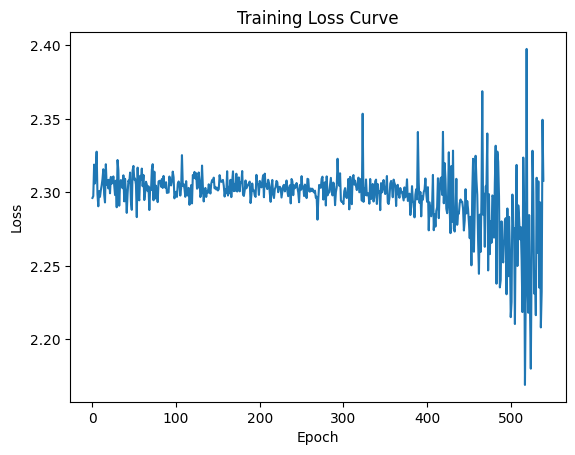

28.338436126708984


In [52]:
#params
dat = dataset(normalized_data[:-100], labels[:-100])
dLoader = DataLoader(dat,batch_size=32,shuffle=True)
EPOCH = 10000
model = lstmattn()
optimizer = optim.Adam(model.parameters(),lr=3e-4,betas=(0.9,0.999))
loss_fn = nn.CrossEntropyLoss()

#train
trainloop(model=model,
          optimizer=optimizer,
          loss_fn=loss_fn,
          dLoader=dLoader,
          EPOCH=EPOCH,
          modelLocation="new_model.pth")




In [58]:
new_model = torch.load("new_model.pth")


#eval dataset
dat2 = dataset(normalized_data[-100:], labels[-100:])
dLoader2 = DataLoader(dat2,batch_size=32,shuffle=False,drop_last=True)

stack = 0
k = 0
new_model.eval()
with torch.no_grad():
    for data,target in dLoader2:
        output = new_model(data)
        max_indices = torch.argmax(output, dim=1)
        print(max_indices)
        print(target)

        for i in range(32):
            k += 1
            if max_indices[i] == target[i]:
                stack += 1
                
    print(f"total correction: {(stack/k)*100}%")
        

    

tensor([3, 7, 3, 3, 0, 5, 3, 7, 5, 7, 0, 7, 7, 3, 3, 7, 5, 5, 3, 3, 7, 3, 5, 3,
        0, 7, 7, 9, 3, 7, 0, 7])
tensor([4, 3, 2, 8, 6, 5, 9, 1, 7, 0, 6, 1, 4, 7, 8, 0, 9, 2, 5, 3, 0, 9, 4, 7,
        3, 6, 5, 1, 8, 2, 8, 3])
tensor([3, 5, 5, 9, 5, 7, 5, 5, 5, 3, 5, 3, 5, 7, 3, 3, 3, 3, 5, 0, 3, 7, 0, 5,
        5, 7, 3, 3, 5, 9, 3, 7])
tensor([6, 1, 7, 0, 5, 9, 4, 2, 1, 8, 7, 4, 6, 0, 3, 9, 2, 5, 1, 3, 4, 2, 0, 5,
        7, 9, 6, 8, 9, 8, 3, 4])
tensor([7, 3, 3, 5, 3, 7, 7, 4, 3, 5, 3, 3, 5, 3, 3, 3, 5, 3, 0, 5, 5, 7, 0, 0,
        3, 5, 5, 3, 5, 5, 0, 5])
tensor([6, 0, 1, 2, 7, 5, 3, 9, 0, 1, 5, 7, 4, 2, 6, 8, 4, 0, 7, 9, 3, 1, 8, 2,
        5, 6, 1, 4, 0, 9, 5, 2])
total correction: 7.291666666666667%
